**WARNING**
Gridsearch cell takes 10-15 minutes to run. 

Imports

In [57]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from bs4 import BeautifulSoup        
import nltk
from nltk.corpus import stopwords 
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer 
import regex as re
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

Read in original (first scrape) relationship csv.

In [2]:
relationship = pd.read_csv('datasets/relationship.csv')
relationship.head()

Unnamed: 0      id                author  \
0           0  b2nc2f               eganist   
1           1  ca66sv  throwawaynocollege01   
2           2  c9ztfk         thegoodtwin28   
3           3  ca62qi           bigkyrososa   
4           4  ca8eih          grizzythekid   

                                               title  \
0  [meta] Think of the comments as an inverted Ub...   
1  Mom had an affair 18 years ago, I [18M] am the...   
2  UPDATE: I'm thinking of distancing myself from...   
3  General Advice: You Don't Require Evidence/Con...   
4  I just found out that my daughter is not my da...   

                                            selftext            timestamp  \
0  Since two or three times a week we end up remo...  2019-03-18 20:04:08   
1  Pretty much the title. I have no idea how to p...  2019-07-07 12:13:03   
2  Thank you for all the helpful comments.\n\nA l...  2019-07-06 22:52:54   
3  Just some general relationship advice after ob...  2019-07-07 11:58:29   
4  So my SO of 4+ years just confessed that my da...  2019-07-07 16:03:19   

   num_comments    ups            subreddit  
0            52   3153  relationship_advice  
1          5732  21144  relationship_advice  
2           620   8427  relationship_advice  
3            39    202  relationship_advice  
4            83     69  relationship_advice

Read in original (first scrape) dating csv.

In [3]:
dating = pd.read_csv('datasets/dating.csv')
dating.head()

Unnamed: 0      id          author  \
0           0  c5gnfz   TheYellowRose   
1           1  c9sy1z   AutoModerator   
2           2  ca6n6n   C0nfusedGiirl   
3           3  ca8zs0  thatviolabinch   
4           4  c9xmsw       Raziasaur   

                                               title  \
0  [SERIOUS] What are some good ways to build up ...   
1       Daily Free-for-all Discussion- July 06, 2019   
2  I hate when guys didn't respond and left me gu...   
3  To the right person, you will perfectly make s...   
4  If you have an unreciprocated crush on a frien...   

                                            selftext            timestamp  \
0                                                NaN  2019-06-25 22:28:55   
1  Welcome to /r/dating_advice. Please use this d...  2019-07-06 12:13:58   
2  That's getting annoyed and time-wasting!\n\nI ...  2019-07-07 13:08:02   
3  I guess this is kind of obvious, but I wanted ...  2019-07-07 16:56:26   
4  I can‚Äôt tell you how many friendships have bee...  2019-07-06 19:34:47   

   num_comments   ups      subreddit  
0            52   104  dating_advice  
1             1     4  dating_advice  
2           123   348  dating_advice  
3             6    52  dating_advice  
4           162  2237  dating_advice

In [4]:
# train = pd.concat(objs=[relationship, dating], axis='rows', ignore_index=True)
# original concatonation on first scrape 

Read in final csv with two scrapes from each subreddit.

In [30]:
train = pd.read_csv("datasets/big_train.csv")

In [31]:
print(train.shape)
train.head()

(3845, 9)


Unnamed: 0      id             author  \
0           0  cc1xgw            Zxnobia   
1           1  cc1ro7  kittenlikeunicorn   
2           2  cc1ppg     whyisthisthrow   
3           3  cc1p2b        lustinglost   
4           4  cc1j09   ScaredAboutScars   

                                               title  \
0                        When is it getting serious?   
1  I am having anxiety about a guy I just started...   
2  I feel like shit, and a moron, with nobody to ...   
3  How to deal with dates you don't feel a connec...   
4   Am I shallow for screening out introverted guys?   

                                            selftext            timestamp  \
0  Hey, I‚Äôm relatively new to dating and therefor...  2019-07-11 21:54:37   
1  I want to have another date, we‚Äôve already wen...  2019-07-11 21:41:30   
2  I met this girl around 4 years ago. At the tim...  2019-07-11 21:37:04   
3  So you are dating around with different people...  2019-07-11 21:35:33   
4  I feel like a terrible person for this but I s...  2019-07-11 21:21:50   

   num_comments  ups      subreddit  
0             1    1  dating_advice  
1             1    1  dating_advice  
2             1    2  dating_advice  
3             1    2  dating_advice  
4            14    0  dating_advice

In [32]:
train.tail()

Unnamed: 0      id                author  \
3840        3873  c86o6u              mirphbla   
3841        3874  c85neu         superpeephole   
3842        3875  c860py          sushilover77   
3843        3876  c878q5  randomproblems2today   
3844        3877  c8akrw          LostAsFuck98   

                                                  title  \
3840  How to continue with a good friend (29f)? Ask ...   
3841                        How do you meet new people?   
3842                    Date with a YouTube Personality   
3843  I(23f) see some red flags in a very new situat...   
3844  The lack of intimacy is killing me NSFW. Sorry...   

                                               selftext            timestamp  \
3840  Hey there.. (30m over here)\n\nSo first of all...  2019-07-02 08:23:47   
3841           Usually in person? In apps? I'm curious.  2019-07-02 06:11:16   
3842  I‚Äôve (26F) been watching this YouTuber (29M) (...  2019-07-02 06:56:47   
3843  I'm (23F) and the guy I'm "dating" is (29M). I...  2019-07-02 09:42:07   
3844  My boyfriend(21) and I (f21), have been togeth...  2019-07-02 15:27:13   

      num_comments  ups      subreddit  
3840             4    4  dating_advice  
3841             9    7  dating_advice  
3842             9    5  dating_advice  
3843             9    3  dating_advice  
3844             6    1  dating_advice

In [33]:
train.iloc[980:990, :]
#checking to make sure the index doesn't start over at 0 where the Dataframes were concatonated 

Unnamed: 0      id                author  \
980         980  ca8w9k      ItachiUchiha1997   
981         981  ca8vpe  tinychameleoncatcher   
982         982  ca8r68         areddituser44   
983         983  ca8ppu  pm_me_ur_fave_murder   
984         984  ca8jh5          teddysready1   
985         985  ca8j9p      mysteryduckworld   
986         986  caomx7            aspicer101   
987         987  caomuh             Tiathomas   
988         988  caomsk              emstyler   
989         989  caoml0   bf_advice_throwaway   

                                                 title  \
980  Do I really stand a chance with this girl? My ...   
981  Long and complicated situation with my ex-girl...   
982                    Great first date. Awful texter?   
983  I (25F) think i need to break up with my bf (3...   
984  How do you navigate non-exclusive relationship...   
985  Should it matter the amount of people someone ...   
986  My 26yr old GF that has OCD with staring compu...   
987                          Best friend becomes lover   
988  I (30M) think I made a humongous mistake break...   
989  24 F relationship with 23 M ended suddenly. I ...   

                                              selftext            timestamp  \
980  So, there is this co-worker of mine (23F). It'...  2019-07-07 16:47:55   
981  I still have extremely strong feelings for my ...  2019-07-07 16:46:33   
982  So I (M30) has a great date a few days ago wit...  2019-07-07 16:35:10   
983  I‚Äôve been in this sub a LOT lately. Dating is ...  2019-07-07 16:31:38   
984  I've been in a casual relationship (non-exclus...  2019-07-07 16:15:43   
985  Throw away account to keep this anonymous\nI‚Äôv...  2019-07-07 16:15:12   
986  This is my first time dating a person with OCD...  2019-07-08 18:12:14   
987  Hi ! I have fallen in love with my childhood b...  2019-07-08 18:12:05   
988  I think I could use some help with clarity her...  2019-07-08 18:11:59   
989  I do not know how to navigate the plethora of ...  2019-07-08 18:11:30   

     num_comments  ups            subreddit  
980             5    3        dating_advice  
981             7    3        dating_advice  
982            17    4        dating_advice  
983             3    4        dating_advice  
984             2    3        dating_advice  
985            17    5        dating_advice  
986             0    1  relationship_advice  
987             0    1  relationship_advice  
988             0    1  relationship_advice  
989             0    1  relationship_advice

Check for null values.

In [34]:
train.isnull().mean()

Unnamed: 0      0.000000
id              0.000000
author          0.000000
title           0.000000
selftext        0.017685
timestamp       0.000000
num_comments    0.000000
ups             0.000000
subreddit       0.000000
dtype: float64

Since the null rows only make up less than 2% of my rows, I will just drop them. 

In [35]:
train.dropna(inplace=True)

In [36]:
train.isnull().sum()

Unnamed: 0      0
id              0
author          0
title           0
selftext        0
timestamp       0
num_comments    0
ups             0
subreddit       0
dtype: int64

Continuing to clean the data, I'll drop unncessary columns. 

In [37]:
train.drop(columns = ['Unnamed: 0'], inplace = True)


Check the shape after dropping rows and columns.

In [38]:
train.shape


(3777, 8)

Check data types to make sure they are in a form that is useful for processing, and everything makes sense so far.

In [39]:
train.dtypes

id              object
author          object
title           object
selftext        object
timestamp       object
num_comments     int64
ups              int64
subreddit       object
dtype: object

In [40]:
train[['title', 'selftext']].head()

title  \
0                        When is it getting serious?   
1  I am having anxiety about a guy I just started...   
2  I feel like shit, and a moron, with nobody to ...   
3  How to deal with dates you don't feel a connec...   
4   Am I shallow for screening out introverted guys?   

                                            selftext  
0  Hey, I‚Äôm relatively new to dating and therefor...  
1  I want to have another date, we‚Äôve already wen...  
2  I met this girl around 4 years ago. At the tim...  
3  So you are dating around with different people...  
4  I feel like a terrible person for this but I s...

Combine the two text columns, `title` and `selftext` together into one new column called `all_text`

In [41]:
train['all_text'] = train['title'] + train['selftext']

Binarize the target `y` column values to be 0 and 1.

In [42]:
train['subreddit'].unique()

array(['dating_advice', 'relationship_advice'], dtype=object)

In [43]:
train['subreddit'] = train['subreddit'].map({'dating_advice': 0, 'relationship_advice': 1})
# binarizing my target(y) column using .map

In [44]:
train['subreddit'].value_counts()
#checking to see if it worked 

1    1971
0    1806
Name: subreddit, dtype: int64

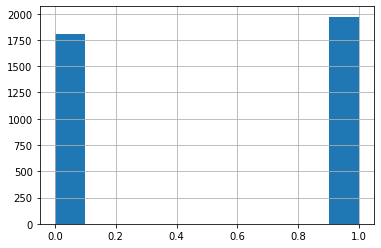

In [45]:
train['subreddit'].hist();

In [46]:
train.head()
#checking to see if all of the above applied to my DataFrame.

id             author  \
0  cc1xgw            Zxnobia   
1  cc1ro7  kittenlikeunicorn   
2  cc1ppg     whyisthisthrow   
3  cc1p2b        lustinglost   
4  cc1j09   ScaredAboutScars   

                                               title  \
0                        When is it getting serious?   
1  I am having anxiety about a guy I just started...   
2  I feel like shit, and a moron, with nobody to ...   
3  How to deal with dates you don't feel a connec...   
4   Am I shallow for screening out introverted guys?   

                                            selftext            timestamp  \
0  Hey, I‚Äôm relatively new to dating and therefor...  2019-07-11 21:54:37   
1  I want to have another date, we‚Äôve already wen...  2019-07-11 21:41:30   
2  I met this girl around 4 years ago. At the tim...  2019-07-11 21:37:04   
3  So you are dating around with different people...  2019-07-11 21:35:33   
4  I feel like a terrible person for this but I s...  2019-07-11 21:21:50   

   num_comments  ups  subreddit  \
0             1    1          0   
1             1    1          0   
2             1    2          0   
3             1    2          0   
4            14    0          0   

                                            all_text  
0  When is it getting serious?Hey, I‚Äôm relatively...  
1  I am having anxiety about a guy I just started...  
2  I feel like shit, and a moron, with nobody to ...  
3  How to deal with dates you don't feel a connec...  
4  Am I shallow for screening out introverted guy...

Save to csv.

In [47]:
# train.to_csv('datasets/clean_big_train.csv')
# commented out to not override original save

Check for descriptive statistics.

In [48]:
train.describe()

num_comments           ups    subreddit
count   3777.000000   3777.000000  3777.000000
mean      13.374106     36.393699     0.521843
std      109.186185    484.645303     0.499589
min        0.000000      0.000000     0.000000
25%        3.000000      1.000000     0.000000
50%        5.000000      1.000000     1.000000
75%        9.000000      3.000000     1.000000
max     5732.000000  21144.000000     1.000000

Instantiate Regular Expressions Tokenizer.

In [49]:
tokenizer = RegexpTokenizer('\w+|\$[\d\.]+|\S+')

Tokenize the two text columns, `title` and `selftext`.

In [50]:
train['token_titles'] = train['title'].apply(tokenizer.tokenize)

In [51]:
train['token_selftext'] = train['selftext'].apply(tokenizer.tokenize)

In [52]:
train.head()

id             author  \
0  cc1xgw            Zxnobia   
1  cc1ro7  kittenlikeunicorn   
2  cc1ppg     whyisthisthrow   
3  cc1p2b        lustinglost   
4  cc1j09   ScaredAboutScars   

                                               title  \
0                        When is it getting serious?   
1  I am having anxiety about a guy I just started...   
2  I feel like shit, and a moron, with nobody to ...   
3  How to deal with dates you don't feel a connec...   
4   Am I shallow for screening out introverted guys?   

                                            selftext            timestamp  \
0  Hey, I‚Äôm relatively new to dating and therefor...  2019-07-11 21:54:37   
1  I want to have another date, we‚Äôve already wen...  2019-07-11 21:41:30   
2  I met this girl around 4 years ago. At the tim...  2019-07-11 21:37:04   
3  So you are dating around with different people...  2019-07-11 21:35:33   
4  I feel like a terrible person for this but I s...  2019-07-11 21:21:50   

   num_comments  ups  subreddit  \
0             1    1          0   
1             1    1          0   
2             1    2          0   
3             1    2          0   
4            14    0          0   

                                            all_text  \
0  When is it getting serious?Hey, I‚Äôm relatively...   
1  I am having anxiety about a guy I just started...   
2  I feel like shit, and a moron, with nobody to ...   
3  How to deal with dates you don't feel a connec...   
4  Am I shallow for screening out introverted guy...   

                                        token_titles  \
0                [When, is, it, getting, serious, ?]   
1  [I, am, having, anxiety, about, a, guy, I, jus...   
2  [I, feel, like, shit, ,, and, a, moron, ,, wit...   
3  [How, to, deal, with, dates, you, don, 't, fee...   
4  [Am, I, shallow, for, screening, out, introver...   

                                      token_selftext  
0  [Hey, ,, I, ‚Äôm, relatively, new, to, dating, a...  
1  [I, want, to, have, another, date, ,, we, ‚Äôve,...  
2  [I, met, this, girl, around, 4, years, ago, .,...  
3  [So, you, are, dating, around, with, different...  
4  [I, feel, like, a, terrible, person, for, this...

Compare distribution of numerical column `num_comments`.

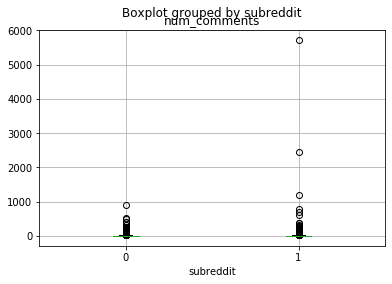

In [53]:
train.boxplot('num_comments', by="subreddit")

Create a function for finding the most frequent words in the `title` and `selftext` columns.

In [54]:
def get_top_n_words(corpus, n=None):
    # instantiate countvectorizer with paramater to remove stop words and fit to data.
    cvec = CountVectorizer(stop_words = 'english').fit(corpus)
    # transform corpus.
    bag_of_words = cvec.transform(corpus)
    # convert to a numpy matrix
    sum_words = bag_of_words.sum(axis=0) 
    #find the words and their counts 
    words_freq = [(word, sum_words[0, idx]) for word, idx in cvec.vocabulary_.items()]
    #sort the words from most frequent to least
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

#code adapted from https://towardsdatascience.com/a-complete-exploratory-data-analysis-and-visualization-for-text-data-29fb1b96fb6a

Run a for loop to find the top 20 most frequent words for the `title` column.

In [58]:
common_words = get_top_n_words(train['title'], 20)
for word, freq in common_words:
    print(word, freq)

relationship 310
girlfriend 278
boyfriend 277
girl 273
friend 265
know 251
don 236
dating 212
like 201
date 192
advice 182
help 182
want 180
just 173
need 156
ex 154
feel 150
guy 139
gf 126
friends 121


Run a for loop to find the top 20 most frequent words for the `selftext` column.

In [59]:
common_words = get_top_n_words(train['selftext'], 20)
for word, freq in common_words:
    print (word, freq)


just 6928
like 6410
don 4751
know 4524
time 4223
really 4024
ve 3896
want 3875
feel 3259
said 3110
relationship 2886
things 2589
friends 2523
told 2474
didn 2262
think 2230
going 2183
got 1910
girl 1800
day 1762


Set X (features) and y (target)

In [60]:
X = train['all_text']
y = train['subreddit']

Find the baseline accuracy score. If we always pick the value that is most common variable we'll be right 63.3% of the time.

In [61]:
y.value_counts(normalize=True)

1    0.521843
0    0.478157
Name: subreddit, dtype: float64

Train test split

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    stratify=y, #to keep the same balance of y in the test and train data
                                                    random_state = 42)

In [174]:
X_train

610     Why does he keep looking at my social media?We...
2262    I have a problem and idk what to doSo basicall...
2765    I (29M) am having some complicated feelings to...
2349    I (25M) am dating a girl (19F) for a while but...
1733    I‚Äôm (18F) starting to relapse into my depressi...
3531    How do I stop giving off the vibe that I'm des...
2972    If anyone would like to chat privately about t...
3036    Told a girl how I feel and haven't talked to h...
2919    Heart broken by somebody I wasn‚Äôt even in a re...
3207    Missing my Ex(gf) after getting dumped from 7 ...
978     Dating at work?So I (22F) have recently starte...
1352    Is it okay to ‚Äúbreakup‚Äù over text in this situ...
61      How do I stop crushing on girls who are nice t...
811     I (M19) told my crush(F19) that I had blue bal...
3543    How would you slowly ask out/ get to know appr...
408     what do i get my boyfriend?im 16 year old fema...
3006    Was he flirting with me?So due to my social an...
3630  

In [64]:
X_train.dtypes

dtype('O')

In [65]:
X_test.shape

(945,)

In [66]:
X_train.isnull().sum()

0

In [67]:
X_train.head()

610     Why does he keep looking at my social media?We...
2262    I have a problem and idk what to doSo basicall...
2765    I (29M) am having some complicated feelings to...
2349    I (25M) am dating a girl (19F) for a while but...
1733    I‚Äôm (18F) starting to relapse into my depressi...
Name: all_text, dtype: object

Here I practiced cleaning the data on just one document first.

In [68]:
# # soup = BeautifulSoup(X_train)
# # print(soup.get_text())

# letters_only = re.sub("[^a-zA-Z]", " ", soup.get_text())   

# #letters_only[0:150]

# lower_case = letters_only.lower()

# # Split lower_case up at each space.
# words = lower_case.split()

# words[0:15]

# print(stopwords.words('english'))

# words = [w for w in words if w not in stopwords.words('english')]

# print(words)

Instantiate Lemmatizer

In [69]:
lemmatizer = WordNetLemmatizer()

Practice lemmatizing

In [70]:
#commented out so as to no cause errors when running all cells

# lem_words = [lemmatizer.lemmatize(i) for i in words]
# len(lem_words)

# for i in range(len(words)):
#     if words[i] != lem_words[i]:
#         print(words[i], lem_words[i])

Instantiate Stemmer

In [71]:
p_stemmer = PorterStemmer()

Practie stemming

In [72]:
#commented out so as to no cause errors when running all cells

# stem_words = [p_stemmer.stem(i) for i in words]

# len(stem_words)

# for i in range(len(words)):
#     if words[i] != stem_words[i]:
#         print(words[i], stem_words[i])

Create a function to turn the posts into a list of words.

In [73]:
def post_to_words(self_text):
    soup_text = BeautifulSoup(self_text).get_text()  #remove HTML
    letters = re.sub("[^a-zA-Z]", " ", soup_text) #remove non-letters
    words = letters.lower().split() #tokenize(split) and make all words lowercase 
    stops = set(stopwords.words('english')) #find stop words 
    keep_words = [w for w in words if w not in stops] #remove stop words 
    # lem_words = [lemmatizer.lemmatize(i) for i in keep_words] 
        
    return(" ".join(keep_words)) #join the words back into one string.

# adapted from Matt Brem's lecture code 

In [74]:
# post_to_words(X_train['selftext'][0])

In [75]:
#test 
# for i in X_train['selftext']:
#     post_to_words(i)

In [76]:
total_posts = train.shape[0]
print(f'There are {total_posts} posts.')

# Initialize an empty list to hold the clean reviews.
clean_train_posts = []
clean_test_posts = []

There are 3777 posts.


In [77]:
print("Cleaning the training set of reddit posts")

j = 0
for i in X_train:
    clean_train_posts.append(post_to_words(i))
j += 1

print("Cleaning the test set of reddit posts")

for test_post in X_test:
    clean_test_posts.append(post_to_words(test_post))
j =+ 1

Cleaning the training set of reddit posts
Cleaning the test set of reddit posts


In [78]:
len(clean_train_posts)

2832

In [79]:
len(clean_test_posts)

945

In [80]:
type(clean_train_posts)

list

Instantiate Count Vectorizer.

In [81]:
cvec = CountVectorizer()

Fit

In [82]:
cvec.fit(clean_train_posts)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

Transform

In [83]:
train_features = cvec.transform(clean_train_posts)

In [84]:
test_features = cvec.transform(clean_test_posts)

In [85]:
train_features.shape

(2832, 15370)

Turn it into a DataFrame.

In [86]:
X_train_vec = pd.DataFrame(train_features.toarray(),
                           columns=cvec.get_feature_names())

In [87]:
X_test_vec = pd.DataFrame(test_features.toarray(),
                         columns=cvec.get_feature_names())

In [88]:
X_test_vec.head()

aa  aau  ab  aback  abandon  abandoned  abandoning  abandonment  abandons  \
0   0    0   0      0        0          0           0            0         0   
1   0    0   0      0        0          0           0            0         0   
2   0    0   0      0        0          0           0            0         0   
3   0    0   0      0        0          0           0            0         0   
4   0    0   0      0        0          0           0            0         0   

   abby  ...  zone  zoned  zonei  zones  zoning  zoo  zoology  zoomed  zq  \
0     0  ...     0      0      0      0       0    0        0       0   0   
1     0  ...     0      0      0      0       0    0        0       0   0   
2     0  ...     0      0      0      0       0    0        0       0   0   
3     0  ...     0      0      0      0       0    0        0       0   0   
4     0  ...     0      0      0      0       0    0        0       0   0   

   zzog  
0     0  
1     0  
2     0  
3     0  
4     0  

[5 rows x 15370 columns]

Find most frequest words on cleaned data.

code adapted from Susan Li: https://towardsdatascience.com/a-complete-exploratory-data-analysis-and-visualization-for-text-data-29fb1b96fb6a

In [89]:
sum_words = train_features.sum(axis=0) 
words_freq = [(word, sum_words[0, idx]) for word, idx in cvec.vocabulary_.items()]
words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)

In [90]:
words_freq[:21]

[('like', 4991),
 ('know', 3652),
 ('time', 3230),
 ('really', 3138),
 ('want', 3077),
 ('would', 2782),
 ('feel', 2639),
 ('get', 2617),
 ('said', 2432),
 ('relationship', 2297),
 ('one', 2067),
 ('friends', 2029),
 ('even', 2000),
 ('told', 1944),
 ('things', 1932),
 ('go', 1918),
 ('back', 1853),
 ('think', 1756),
 ('never', 1753),
 ('going', 1739),
 ('much', 1532)]

Instantiate Logistic Regression.

In [91]:
lr_vec = LogisticRegression()

Fit

In [93]:
lr_vec.fit(X_train_vec, y_train)

/Users/rachelkoenig/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

Train score: 99.5%

In [94]:
lr_vec.score(X_train_vec, y_train)

0.9950564971751412

Test score: 74.6%

In [95]:
lr_vec.score(X_test_vec, y_test)

0.7216931216931217

Cross val score: 74.5%

In [96]:
cross_val_score(lr_vec, X_train_vec, y_train, cv=5).mean()

/Users/rachelkoenig/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/rachelkoenig/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/rachelkoenig/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/rachelkoenig/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/rachelkoenig/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Defau

0.7485740868414915

What if I modify the CVEC parameters?

In [97]:
cvec_12gram = CountVectorizer(ngram_range=(1,2), #will look at individual words and words pairs
                             min_df=3) #words must be in at leat 3 documents to be considered

In [98]:
cvec_12gram.fit(clean_train_posts)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=3,
        ngram_range=(1, 2), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [99]:
X_train_12gram = cvec_12gram.transform(clean_train_posts)

In [100]:
type(X_train_12gram)

scipy.sparse.csr.csr_matrix

In [101]:
X_train_12gram_df = pd.DataFrame(X_train_12gram.toarray(),
                                 columns = cvec_12gram.get_feature_names())


In [102]:
X_train_12gram_df.head()

aa  ab  aback  abandon  abandoned  abandoning  abandonment  abandons  \
0   0   0      0        0          0           0            0         0   
1   0   0      0        0          0           0            0         0   
2   0   0      0        0          0           0            0         0   
3   0   0      0        0          0           0            0         0   
4   0   0      0        0          0           0            0         0   

   ability  able  ...  yrs  yrs old  ys  ys lt  yup  zero  zone  zoned  \
0        0     0  ...    0        0   0      0    0     0     0      0   
1        0     0  ...    0        0   0      0    0     0     0      0   
2        0     0  ...    0        0   0      0    0     0     0      0   
3        0     0  ...    0        0   0      0    0     0     0      0   
4        0     1  ...    0        0   0      0    0     0     0      0   

   zoning  zoo  
0       0    0  
1       0    0  
2       0    0  
3       0    0  
4       0    0  

[5 rows x 26328 columns]

In [103]:
X_test_12gram = cvec_12gram.transform(clean_test_posts)

In [104]:
X_test_12gram_df = pd.DataFrame(X_test_12gram.toarray(),
                               columns = cvec_12gram.get_feature_names())

In [105]:
X_test_12gram_df.head()

aa  ab  aback  abandon  abandoned  abandoning  abandonment  abandons  \
0   0   0      0        0          0           0            0         0   
1   0   0      0        0          0           0            0         0   
2   0   0      0        0          0           0            0         0   
3   0   0      0        0          0           0            0         0   
4   0   0      0        0          0           0            0         0   

   ability  able  ...  yrs  yrs old  ys  ys lt  yup  zero  zone  zoned  \
0        0     0  ...    0        0   0      0    0     0     0      0   
1        0     0  ...    0        0   0      0    0     0     0      0   
2        0     0  ...    0        0   0      0    0     0     0      0   
3        0     1  ...    0        0   0      0    0     0     0      0   
4        0     0  ...    0        0   0      0    0     0     0      0   

   zoning  zoo  
0       0    0  
1       0    0  
2       0    0  
3       0    0  
4       0    0  

[5 rows x 26328 columns]

In [106]:
lr_vec.fit(X_train_12gram, y_train)

/Users/rachelkoenig/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [107]:
lr_vec.score(X_train_12gram, y_train)

0.998587570621469

Train score with cvec n_gram range(1,2) and min_df=3:  99.8%

In [108]:
lr_vec.score(X_test_12gram, y_test)

0.7428571428571429

Test score: 75.7%

In [109]:
cross_val_score(lr_vec, X_train_12gram, y_train, cv=5).mean()

/Users/rachelkoenig/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.7634250916317271

Cross val score: 76%

Score increases by one point for test and cross val.

Let's try pipeline next!

In [111]:
pipe = Pipeline([('cvec', CountVectorizer()), 
                ('lr_pipe', LogisticRegression())])


In [112]:
cross_val_score(pipe, X_train, y_train, cv=5).mean()

/Users/rachelkoenig/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.7528181219895573

In [113]:
pipe.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('cvec', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))])

In [114]:
pipe.score(X_train, y_train)

0.9978813559322034

In [115]:
pipe.score(X_test, y_test)

0.7343915343915344

In [116]:
pipe_params = {
    'cvec__max_features': [2500, 3000, 4000, 5000],
    'cvec__min_df': [2, 3],
    'cvec__max_df': [.9, .95, .98],
    'cvec__ngram_range': [(1,1), (1,2), (2,3)]
}
gs = GridSearchCV(pipe, param_grid=pipe_params, cv=3)

gs.fit(X_train, y_train)

print(gs.best_score_)

gs.best_params_

/Users/rachelkoenig/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.7602401129943502


{'cvec__max_df': 0.98,
 'cvec__max_features': 5000,
 'cvec__min_df': 3,
 'cvec__ngram_range': (1, 2)}

Gridsearch cross val score: 76%
Best parameters:  
cvec__max_df: 0.98  
cvec__max_features: 5000  
cvec__min_df: 2  
cvec__ngram_range: (1, 2)

In [117]:
gs.score(X_train, y_train)

0.998587570621469

Gridsearch train score: 99.9%

In [118]:
gs.score(X_test, y_test)

0.7365079365079366

Gridsearch test score: 74%

Find the coefficients and features from the gridsearch.

In [120]:
coefs = list(np.exp(gs.best_estimator_.named_steps['lr_pipe'].coef_[0]))

In [121]:
features = gs.best_estimator_.named_steps['cvec'].get_feature_names()

In [122]:
dictionary = dict(zip(features, coefs))

In [123]:
coef_df = pd.DataFrame.from_dict(dictionary, orient='index')

Here I can seee which 20 individual words and/or bi-grams are having the biggest influence on the model.

In [124]:
coef_df[0].sort_values(ascending=False).head(30)

my boyfriend    2.661509
literally       2.349002
wife            2.270028
up and          2.224857
essentially     2.194719
update          2.157443
got the         2.112019
mostly          2.097368
others          2.002450
partner         1.974992
asked if        1.969277
graduate        1.930048
at my           1.928458
is an           1.914759
says            1.905388
white           1.903753
except          1.897766
the other       1.896916
it but          1.893022
someone else    1.892871
affection       1.869167
phone           1.865444
your            1.862859
lied to         1.860568
parents         1.850156
all the         1.839822
end             1.813631
19f             1.811425
that he         1.809776
last night      1.807080
Name: 0, dtype: float64

Let's see what KNN does.

In [125]:
from sklearn.neighbors import KNeighborsClassifier

In [126]:
knn = KNeighborsClassifier()

In [127]:
knn.fit(X_train_vec, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

KNN with default paramaters Train score: 74.7%

In [128]:
knn.score(X_train_vec, y_train)

0.7471751412429378

KNN test score predicted worse than my baseline model: 58%

In [129]:
knn.score(X_test_vec, y_test)

0.6264550264550265

KNN cross val score: 56%

In [130]:
cross_val_score(knn, X_train_vec, y_train, cv=5).mean()

0.6041818547919426

KNN did not help and did way worse than my first attempt so I'm going to go back to digging deeper into the features using TfidfVectorizer.

In [131]:
tfidf_vectorizer = TfidfVectorizer(stop_words=['relationship', 'girlfriend', 
                                               'boyfriend', 'friends', 'friends', 
                                               'just', 'like', 'dating', 'know',
                                              'time', 'want', 'really', 'would',
                                              'get', 'feel', 'said', 'things', 'think'],
                                   ngram_range=(1,2),
                                   max_df=0.9,
                                   min_df= 2,
                                   max_features=5000
                                  )

tfidf_vectorizer.fit_transform(clean_train_posts)

<2832x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 259306 stored elements in Compressed Sparse Row format>

Transform

In [132]:
X_train_tfidf = tfidf_vectorizer.transform(clean_train_posts)
X_test_tfidf = tfidf_vectorizer.transform(clean_test_posts) 

Instantiate a new Logistic Regression so as not to override the previous.

In [133]:
lr = LogisticRegression()

Fit the model.

In [134]:
lr.fit(X_train_tfidf, y_train)

/Users/rachelkoenig/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

Train score went down to 88%

In [173]:
X_train_tfidf

<2832x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 259306 stored elements in Compressed Sparse Row format>

In [135]:
lr.score(X_train_tfidf, y_train)

0.8802966101694916

Test score stayed the same at 76%

In [136]:
lr.score(X_test_tfidf, y_test)

0.7576719576719577

Cross val score stayed the same at 79%.

In [137]:
cross_val_score(lr, X_train_tfidf, y_train, cv=5).mean()

/Users/rachelkoenig/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.7913253753992989

In [139]:
X_train_tfidf_df = pd.DataFrame(X_train_tfidf.toarray(),
                               columns = tfidf_vectorizer.get_feature_names())

In [140]:
X_train_tfidf_df.shape

(2832, 5000)

In [141]:
tfidf_coefs = (np.exp(lr.coef_)[0])

tfidf_features = tfidf_vectorizer.get_feature_names()

tfidf_coef_dict = dict(zip(tfidf_features, tfidf_coefs))

In [142]:
tfidf_df = pd.DataFrame.from_dict(tfidf_coef_dict, orient='index')

In [143]:
tfidf_df.head()

0
aback      1.031485
abandon    1.005342
abandoned  1.084123
ability    1.074378
able       1.491365

 These are the most highly predictive words in my

In [145]:
tfidf_df[0].sort_values(ascending=False).head(15)

parents     8.271122
wife        6.659989
love        6.591230
together    6.571395
says        5.413163
break       5.329587
told        5.084645
years       4.997619
phone       4.964687
telling     4.765602
cheated     4.752482
gf          4.619905
dad         4.605839
house       4.463767
married     4.073041
Name: 0, dtype: float64

The word 'parents' is 8.2 times as likely to predict the relationship advice page.

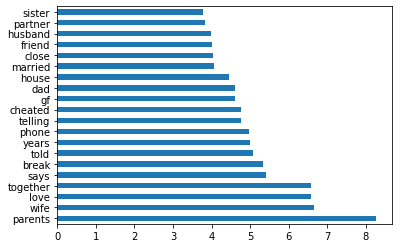

In [146]:
tfidf_df[0].sort_values(ascending=False).head(20).plot(kind='barh')

For my Bayes Model I will use MultinomialNB because it is better than Gaussian and Bernoulli for text processing.  
source: https://medium.com/@awantikdas/a-comprehensive-naive-bayes-tutorial-using-scikit-learn-f6b71ae84431

In [147]:
tfidf_vectorizer_2 = TfidfVectorizer(ngram_range=(2,2),
                                   max_df=0.9,
                                   min_df= 2,
                                   max_features=5000
                                  )

tfidf_vectorizer_2.fit_transform(clean_train_posts)

<2832x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 70736 stored elements in Compressed Sparse Row format>

In [148]:
X_train_2tfidf = tfidf_vectorizer_2.transform(clean_train_posts)
X_test_2tfidf = tfidf_vectorizer_2.transform(clean_test_posts) 

In [149]:
lr_2gram = LogisticRegression()

In [150]:
lr_2gram.fit(X_train_2tfidf, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

Train score: 86.5%

In [151]:
lr_2gram.score(X_train_2tfidf, y_train)

0.9134887005649718

Test score: 73%

In [152]:
lr_2gram.score(X_test_2tfidf, y_test)

0.7174603174603175

Cross val score: 71.6%

In [153]:
cross_val_score(lr_2gram, X_train_2tfidf, y_train, cv=5).mean()

/Users/rachelkoenig/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.7394161203563206

In [154]:
tfidf2_coefs = (np.exp(lr_2gram.coef_)[0])

tfidf2_features = tfidf_vectorizer_2.get_feature_names()

tfidf2_coef_dict = dict(zip(tfidf2_features, tfidf2_coefs))

In [155]:
tfidf2_df = pd.DataFrame.from_dict(tfidf2_coef_dict, orient='index')

In [156]:
tfidf2_df[0].sort_values(ascending=False).head(20)

even though         5.611317
together years      5.510691
two years           4.634633
best friend         4.570926
feel like           4.291885
fast forward        3.829490
really love         3.818500
long distance       3.805249
married years       3.632188
girlfriend years    3.388480
feels like          3.356721
love much           3.329984
last night          3.274148
say anything        3.177706
ys lt               3.117557
live together       3.048700
best friends        3.022717
living together     2.986601
one year            2.912052
told would          2.879537
Name: 0, dtype: float64

In [157]:
from sklearn.naive_bayes import MultinomialNB

In [158]:
mnb = MultinomialNB()

In [159]:
mnb.fit(X_train_vec, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [160]:
mnb.score(X_train_vec, y_train)

0.8848870056497176

In [161]:
mnb.score(X_test_vec, y_test)

0.7587301587301587

In [162]:
y_pred = mnb.predict(X_test_vec)

In [164]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

array([[341, 111],
       [117, 376]])

The confusion matrix shows we have a somewhat low false predictions. 

In [170]:
train[train['all_text'].str.contains('parents') & (train['subreddit'] == 1)]

id                author  \
993   caoli8    horst_from_germany   
996   caol6g         littlelunaa12   
1002  caohoj      lavender-vanilla   
1006  caofgl             dukes1998   
1010  caoed9       throwaway1306__   
1011  caod1d        drawforKeysT_T   
1012  caocq9     DrDrakeRamorayEel   
1017  caoc1r     throwitalldown456   
1024  cao9wc         PhoenixAria87   
1026  cao9be    throwaway991100221   
1040  cao56w  chocolatecumdumpster   
1058  canwbn             RoflexKun   
1065  canrpx           Delilah1998   
1066  canrnm          ItchyNarwhal   
1068  canppo           97WaterPolo   
1074  canmr3     moonswavesATnight   
1078  canm12  WiseManSayingNothing   
1079  canlmw       adviceandadvise   
1081  cankf2              boyant24   
1083  caniou         quesomonstruo   
1084  canhj3  throwawayaccountt567   
1085  canhgz         AtharvaChavan   
1090  cangt3           wasabihelp1   
1105  canbbc         quesomonstruo   
1107  canb3i         pastelpanda28   
1116  can5vp           Squidd_Milk   
1120  can3ro                 bhp13   
1124  can37u         steamincoffee   
1133  can0ga        hiroshimasfoot   
1135  camz9y   NotMagicJustScience   
...      ...                   ...   
2758  c9z85g               A_Tamas   
2761  ca1fdb             K_rose315   
2772  ca18c9        AdviceAcct1996   
2779  c9yvzb     amicus_elephantus   
2780  ca16mn     HopefulReputation   
2784  ca12kc                Maukin   
2787  c9yos7        thrxwaway18947   
2791  ca0zs8            bluefox221   
2793  c9r0zf              EmmiRoeo   
2796  ca0vvs              kyliegh0   
2800  c9yf4p        butlikewhythou   
2807  ca0n87       cactuslover6789   
2808  ca0n3e             WrathsTwn   
2817  ca0j4a           kissingfish   
2828  c9y05n             shebulust   
2838  c9xvj1        Uhaulsanderson   
2846  ca02u3  throwAwayCusePPLKnow   
2848  c9xjtg    ilovepickles123456   
2849  ca00tx  MagicalFrostyFlakes1   
2870  c9vn54     completelylost987   
2880  c9zj71             whitekuda   
2886  c9zgyt            flowerfood   
2890  c9iew3         drobthrowaway   
2909  c9wgq1             kyleray96   
2921  c9smky  Pontifex_maximus1996   
2926  c9s7vp         keanuleaves22   
2935  c9yg5p             judeotaji   
2941  c9ycq3            saisbinodm   
2942  c9ycjn      danielleuniverse   
2959  c9xx43        Hungry_Climate   

                                                  title  \
993     Please help - My old family is a complete chaos   
996   I (f,19) was set to be married to my (m,23) ar...   
1002  My [23F] boyfriend [21M] of two years wants me...   
1006  I (20M) am worried I may be getting ‚Äútoo into‚Äù...   
1010  Guy [25M] I'm [22F] seeing has a girl [28F] in...   
1011  My [25/F]friend is having her bday party at my...   
1012  I have a creepy step granddad and I don't know...   
1017  I (34F) worry about being too needy/ clingy in...   
1024  I [30f] don't want to change my last name, my ...   
1026               I am so hurt and confused. Need help   
1040  I met my bf online, lied about his age and how...   
1058  I made a contest with a friend and the prize i...   
1065  [20F] Help with my crippling relationship anxi...   
1066  I (34F) am seeking advice on dealing with an o...   
1068         Girlfriend relationship reoccurring issues   
1074                                         Love Hurts   
1078  (30M) My high school sweet heart and wife (29F...   
1079  My (25M) girlfriend(24F) wants to break up bec...   
1081      Am I in a rut/depressed with my relationship.   
1083  After a falling out my sister in law told the ...   
1084  I‚Äôm tired of helping my little sister with her...   
1085  Me (18M) and my girlfriend (18F) are going thr...   
1090  Boyfriend doesn‚Äôt want to spend time with my f...   
1105  After a falling out my sister in law (32F seco...   
1107  My (20F) boyfriend (19M) thinks planning our f...   
1116  My boyfriend‚Äôs parents track his phone 24/7, a...   
1120  I need urgent advice- Please someone tell me

In [172]:
train['all_text'][1002]

'My [23F] boyfriend [21M] of two years wants me to move to a different state with him so he can go to collegeFirst post, sorry if this is the wrong place to post this. It will be long, my apologies.\n\nTo preface this, I have lived on my own and been financially independent for about 4 years and I moved to a new state a few months ago to be closer to my job and am renting a house with one other person for a great price. My job offers excellent benefits, bonuses, and vacation time. It\'s a stressful job and the pay isn\'t amazing but for a first "grown-up job" out of college, I\'m not doing bad at all. Unfortunately, my moving has put a strain on my relationship as now I am about an hour from where my bf lives with his parents and he only sees me once every week or two. Before that, he would come to see me at my apartment every day and stay over most nights. It became an issue to my roommates because he did not help financially at all but that is a different story (still important to me

In [167]:
train['all_text'][989]

'24 F relationship with 23 M ended suddenly. I feel empty and hollow inside, does this feeling go away?I do not know how to navigate the plethora of emotions I have been feeling this past week. I am looking for closure but he is unable to help me with that and I don‚Äôt know where else to look for closure. I‚Äôm worried about myself- I feel like I am checked out from my life, just going through the motions on autopilot. I have never felt like this before. I miss him constantly, everyday, every moment. Is this normal? \n\nHe meant a lot to me and wants to keep being friends but I don‚Äôt think I could be friends which I conveyed to him. What is the best way to deal with this loss? How do I make healthy choices for myself? I am totally lost.'

In [168]:
train['all_text'][994]

"Not with a boy..but I need advice with my MomI don't even know where to start this just happened...\n\n&amp;#x200B;\n\nMy mom logged in to her verizon account (I pay my own phone bill but it's on her service if that makes sense) and saw that my boyfriend and I talk all day everyday and she got really really mad...she said I had to give her my phone. I gave it to her and she started reading and looking through pictures and she just got more and more mad..I ended up having to delete my snapchat..\n\n&amp;#x200B;\n\nShe kicked me out. She let me grab a hoodie and a pair of jeans, but she took my car keys and she kicked me out of the house. I'm 21 years old. I have no one else to turn to, nowhere else to go...what do I do? I'm currently sitting in the library.."

In [169]:
train['all_text'][2959]

"My (18F) younger brother (17M) and I constantly fight over noise complaints. I'm really sick of it at this point, and I'm lost as to what to do.Hey, guys. For several years my younger brother and I have butted heads - he's incredibly loud while I prefer some peace and quiet. We used to spend a lot of time doing normal sibling squabbling stuff when we were younger, but everything has gotten well past that point and we genuinely do not like each other anymore. \n\nI just recently finished my first semester at a good university only 40 mins away, so I don't need a dorm and I can just live at home. I spend a lot of my time studying, preferably with some quiet, but I don't mind noise such as someone watching TV in the living room, or people over, or whatever. I do feel that my brother is excessively loud and inconsiderate, however. Our rooms are right beside each other, and he has a habit of leaving his room door wide open while he blasts music from a bass-boosted speaker, or take calls at